In [1]:
import pandas as pd
import calour as ca 
import numpy as np
import matplotlib.pyplot as plt
from qiime2 import Artifact
import biom
import seaborn as sns
%matplotlib inline
from scipy import stats
from itertools import combinations
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def sign_level(pvalue):
    if pvalue <= 0.01:
        
        sig="**"
    elif 0.01 <pvalue <= 0.05:
        sig='*'
    else:
        sig=''
    return sig

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [4]:
study=['PRJEB21104','PRJEB21497','PRJEB22107',
       'PRJEB26931',
       'PRJNA310127',
       'PRJNA428883',
       'PRJNA375772','PRJNA495436','PRJNA481413']

In [5]:
df=[]
for i in study:
    df1=pd.read_csv('../../../%s/deblur-results/diversity-analysis/metadata_add_alpha_div.tsv' % i,sep='\t',index_col=0)
    df.append(df1)
md=pd.concat(df)

/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [6]:
md.head()

,Age,BMI,BioProject,CagA,Center_Name,Collection_Date,Condition,Country,Diagnosis,Gender,HP_status,HP_status_,HP_test_method,Histopathological_score,Histopathology,Histopathology(lauren_classification),Hour_collected,Instrument,LibraryLayout,Mean_sequence_length,Mesalamine_administration,Mesalamine_concentration,Name,Note,Other_disease,PGI_PGII_ratio,Ph,Race,Region,SRA_Study,Sample_location,Sample_type,Sequencing_method,Sequencing_region,Subject_id,Tissue,Treatment,Week,Year,_calour_original_abundance,_sample_id,bioproject,faith_pd,gastrin,host_height,host_weight,hp,hp_relative_abundance,observed_otus,paried-sample,pielou_e,primer,sampleloc,sampling_method,shannon,smoker
ERR1995049,NaN,NaN,PRJEB21104,NaN,CGR,NaN,gastric cancer,United Kingdom,gastric cancer,NaN,negative,N,Histology and RUT and Serology,NaN,NaN,NaN,NaN,NaN,PAIRED,NaN,NaN,NaN,ERR1995049,Normal,NaN,1,NaN,NaN,NaN,ERP023334,Body,gastric mucosa,Illumina MiSeq,v1-v2,NaN,NaN,NaN,NaN,NaN,1314.0,ERR1995049,NaN,20.535596,M100,NaN,NaN,positive,78.205101,118,NaN,0.455905,27F _388R,NaN,gastric mucosa biopsy,3.137832,NaN
ERR1995038,NaN,NaN,PRJEB21104,NaN,CGR,NaN,gastric cancer,United Kingdom,gastric cancer,NaN,negative,N,Histology and RUT and Serology,NaN,NaN,NaN,NaN,NaN,PAIRED,NaN,NaN,NaN,ERR1995038,Normal,NaN,2,NaN,NaN,NaN,ERP023334,Body,gastric mucosa,Illumina MiSeq,v1-v2,NaN,NaN,NaN,NaN,NaN,1314.0,ERR1995038,NaN,18.289765,M100,NaN,NaN,positive,11.572394,91,NaN,0.621644,27F _388R,NaN,gastric mucosa biopsy,4.045530,NaN
ERR1995068,NaN,NaN,PRJEB21104,NaN,CGR,NaN,autoimmune atrophic gastritis,United Kingdom,gastritis,NaN,negative,N,Histology and RUT and Serology,NaN,NaN,NaN,NaN,NaN,PAIRED,NaN,NaN,NaN,ERR1995068,Normal,NaN,unk,NaN,NaN,NaN,ERP023334,Body,gastric mucosa,Illumina MiSeq,v1-v2,NaN,NaN,NaN,NaN,NaN,1314.0,ERR1995068,NaN,17.959285,M100,NaN,NaN,negative,0.000000,120,NaN,0.589965,27F _388R,NaN,gastric mucosa biopsy,4.074823,NaN
ERR1995063,NaN,NaN,PRJEB21104,NaN,CGR,NaN,autoimmune atrophic gastritis,United Kingdom,gastritis,NaN,negative,N,Histology and RUT and Serology,NaN,NaN,NaN,NaN,NaN,PAIRED,NaN,NaN,NaN,ERR1995063,Normal,NaN,2,NaN,NaN,NaN,ERP023334,Body,gastric mucosa,Illumina MiSeq,v1-v2,NaN,NaN,NaN,NaN,NaN,1314.0,ERR1995063,NaN,14.590988,M100,NaN,NaN,negative,0.003357,86,NaN,0.619302,27F _388R,NaN,gastric mucosa biopsy,3.979801,NaN
ERR1995100,NaN,NaN,PRJEB21104,NaN,CGR,NaN,healthy,United Kingdom,healthy,NaN,negative,N,Histology and RUT and Serology,NaN,NaN,NaN,NaN,NaN,PAIRED,NaN,NaN,NaN,ERR1995100,Normal,NaN,unk,NaN,NaN,NaN,ERP023334,Body,gastric mucosa,Illumina MiSeq,v1-v2,NaN,NaN,NaN,NaN,NaN,1314.0,ERR1995100,NaN,26.942824,L40,NaN,NaN,negative,0.078782,217,NaN,0.845740,27F _388R,NaN,gastric mucosa biopsy,6.564254,NaN


In [7]:
md['bioproject'].fillna(md['BioProject'],inplace=True)

In [8]:
md.to_csv('metadata_add_alpha_final.csv')

In [9]:
md['bioproject'].replace({'PRJNA481413 gastric mucosa' : 'PRJNA481413'},inplace=True) 


In [10]:
md.rename(columns={'shannon':'Shannon','faith_pd':"Faith's PD",'observed_otus':'Observed ASVs'},
          inplace=True)

In [11]:
alphas=['Shannon',"Faith's PD", 'Observed ASVs']


In [12]:
mdf=md.query('Diagnosis!="PPI"').query('Condition!="autoimmune atrophic gastritis"').query('Condition!="gastric ulcers"').query('Condition!="intraepithelial neoplasia"')
mdf.shape

(2111, 56)

In [13]:
mdf=mdf.dropna(subset=['Diagnosis']) 

In [14]:
mdf=mdf.query('Sample_type!="gastric fluid"').query('Sample_type!="feces"')
mdf.shape

(1999, 56)

In [15]:
d=mdf.query('BioProject=="PRJNA481413" & Sample_location=="Cardia"')
d.index #only one cardia sample,discard it

Index(['SRR7534010'], dtype='object')

In [16]:
mdf=mdf.drop('SRR7534010')
mdf.shape

(1998, 56)

In [17]:
mdf['Sample_location'].fillna(mdf['Tissue'],inplace=True)
mdf['Sample_location'].fillna('unknow',inplace=True)

# alpha div correlation with hp_rel_abundance

In [18]:
mdf['Sample_type'].value_counts()

gastric mucosa    1998
Name: Sample_type, dtype: int64

In [19]:
mdff=mdf.query('Week!=6 &Week !=26') 
#PRJNA495436 Week6 week0 data not included to calculate cor of alpha div and HP abundant

In [20]:
bp=['PRJEB21104',
 'PRJEB21497',
 'PRJEB22107',
 'PRJEB26931',
 'PRJNA310127_China',
 'PRJNA310127_Mexico',
 'PRJNA375772_Inner_Mongolia',
 'PRJNA375772_Xi_an',
'PRJNA428883',
'PRJNA481413',
 'PRJNA495436',
 ]

b=['hp_relative_abundance','Diagnosis']+alphas

hp_cor=pd.DataFrame(columns=alphas,index=bp)
hp_p=pd.DataFrame(columns=alphas,index=bp)

for study in bp:
    
    s=mdff.query('bioproject=="%s"' %study)[b].dropna()
    for alp in alphas:
        r, p = stats.spearmanr(s['hp_relative_abundance'], s[alp])
        #R={0:.4f}.format(r)
        hp_cor.loc[study,alp]=r
        hp_p.loc[study,alp]=p
hp_cor        

,Shannon,Faith's PD,Observed ASVs
PRJEB21104,-0.939712,-0.922983,-0.938197
PRJEB21497,-0.24504,0.0506133,-0.071835
PRJEB22107,-0.908221,-0.759248,-0.788798
PRJEB26931,-0.485931,-0.382369,-0.384355
PRJNA310127_China,-0.698589,-0.550039,-0.578249
PRJNA310127_Mexico,-0.604722,-0.340621,-0.38889
PRJNA375772_Inner_Mongolia,-0.148745,-0.155463,-0.152463
PRJNA375772_Xi_an,-0.204337,-0.0866949,-0.123101
PRJNA428883,-0.439673,-0.209975,-0.264195
PRJNA481413,-0.825178,-0.846573,-0.842974


In [21]:
bp=['PRJEB21104',
 'PRJEB21497',
 'PRJEB22107',
 'PRJEB26931',
 'PRJNA310127_China',
 'PRJNA310127_Mexico',
 'PRJNA375772_Inner_Mongolia',
 'PRJNA375772_Xi_an',
'PRJNA428883',
'PRJNA481413',
 'PRJNA495436',
 ]

b=['hp_relative_abundance','Diagnosis']+alphas

hp_cor=pd.DataFrame(columns=alphas,index=bp)
hp_p=pd.DataFrame(columns=alphas,index=bp)

for study in bp:
    
    s=mdff.query('bioproject=="%s"' %study)[b].dropna()
    for alp in alphas:
        r, p = stats.spearmanr(s['hp_relative_abundance'], s[alp])
        #R={0:.4f}.format(r)
        hp_cor.loc[study,alp]=r
        hp_p.loc[study,alp]=p
hp_cor        
#spearmanr

,Shannon,Faith's PD,Observed ASVs
PRJEB21104,-0.939712,-0.922983,-0.938197
PRJEB21497,-0.24504,0.0506133,-0.071835
PRJEB22107,-0.908221,-0.759248,-0.788798
PRJEB26931,-0.485931,-0.382369,-0.384355
PRJNA310127_China,-0.698589,-0.550039,-0.578249
PRJNA310127_Mexico,-0.604722,-0.340621,-0.38889
PRJNA375772_Inner_Mongolia,-0.148745,-0.155463,-0.152463
PRJNA375772_Xi_an,-0.204337,-0.0866949,-0.123101
PRJNA428883,-0.439673,-0.209975,-0.264195
PRJNA481413,-0.825178,-0.846573,-0.842974


In [22]:
hp_p

,Shannon,Faith's PD,Observed ASVs
PRJEB21104,4.65297e-31,8.07123e-28,9.93372e-31
PRJEB21497,0.191855,0.790539,0.706006
PRJEB22107,1.46598e-10,6.88869e-06,1.68968e-06
PRJEB26931,2.49628e-15,1.34195e-09,1.08463e-09
PRJNA310127_China,7.34492e-24,1.48242e-13,4.05826e-15
PRJNA310127_Mexico,1.29266e-13,0.000115712,8.77992e-06
PRJNA375772_Inner_Mongolia,0.0762291,0.0637333,0.0690899
PRJNA375772_Xi_an,0.00361803,0.221046,0.0816825
PRJNA428883,1.09553e-34,1.8212e-08,1.00763e-12
PRJNA481413,6.44561e-72,3.29482e-79,6.61193e-78


In [23]:
for alp in alphas:
    hp_p[alp]=hp_p[alp].apply(sign_level)

In [24]:
hp_cor=pd.DataFrame(columns=alphas,index=bp,data=hp_cor.values.astype(float)).round(2)

In [25]:
def plot_heatmap(dataplot,shrink=0.2,size=10):
    sig=dataplot.query("alpha=='%s'" %alpha)[['sig','sig_nohp']]
    data=dataplot.query("alpha=='%s'" %alpha)[['with HP','without HP']]  
    
    annot_text = (np.asarray(["{0:.2f}\n{1}".format(data, 
                    sig) for data,sig in zip(data.values.flatten(), sig.values.flatten())])).reshape(data.shape)
    
    sns.heatmap(data, annot=annot_text, fmt='',square=True,cmap='RdBu_r',center=0,
                cbar_kws={"shrink": shrink },annot_kws={'size':size},ax=ax)

    ax.xaxis.tick_top() 
    ax.xaxis.set_label_position('top')
    ax.set_title(alpha)
    plt.setp(ax.get_xticklabels(), rotation=15, ha='left')
    plt.tight_layout()
    ax.set_ylabel('')
    return ax

In [26]:
#sns.set_theme(style='ticks')

Text(-19.942272727272695, 0.5, '')

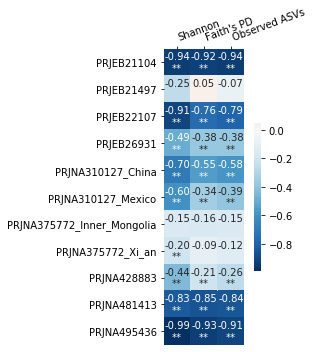

In [27]:
fig,ax = plt.subplots(1,1,figsize = (4,5),sharex=True)

annot_text = (np.asarray(["{0:.2f}\n{1}".format(data, 
                    sig) for data,sig in zip(hp_cor.values.flatten(), hp_p.values.flatten())])).reshape(hp_cor.shape)

sns.heatmap(hp_cor,annot=annot_text,fmt='',square=True,cmap='RdBu_r',center=0,
            cbar_kws={"shrink": 0.5 },ax=ax)

ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')
#ax.set_title(alpha)
plt.setp(ax.get_xticklabels(), rotation=20, ha='left')
plt.tight_layout()
ax.set_ylabel('')

In [28]:
def plot_scatter(df,x,y, title='', cmap=None, cor=stats.spearmanr,group=None, ax=None,color_dict=None, **kwargs):
    '''Plot scatter plot
    df : DataFrame, your data to plot
    '''
    import itertools
    from matplotlib import pyplot as plt
    import seaborn as sns
    if cmap is None:
        cmap = plt.cm.tab10
    colors = itertools.cycle(cmap.colors)
    if ax is None:
        fig, ax = plt.subplots()
    # ax.axis('equal')
    if group is not None:
        for grp, DF in df.groupby(group):
            ax.scatter(DF[x], DF[y],
                       color=color_dict[grp],
                       label=grp,
                       **kwargs)
        ax.legend(loc="lower right")
    else:
        ax.scatter(df[x], df[y], **kwargs)
    sns.regplot(df[x], df[y],scatter=False,ax=ax,line_kws={'color':color_dict[grp], 'alpha':.2})
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title)
    ax.set_xlim([-5,105])
    ax.set_ylim([df[y].min(),df[y].max()+0.2])
    
    if cor is not None:
        r, p = cor(df[x], df[y])
        ax.annotate("r={0:.3f}\np-value={1:.3f}".format(r, p), xy=(.3, .85),fontsize=9, xycoords=ax.transAxes)
    return ax

In [29]:
D=['gastric cancer', 'gastritis', 'healthy','intestinal metaplasia']

In [30]:
colors =plt.cm.tab10.colors
color_dict={}
for d,c in zip(D,colors):
    color_dict[d]=c

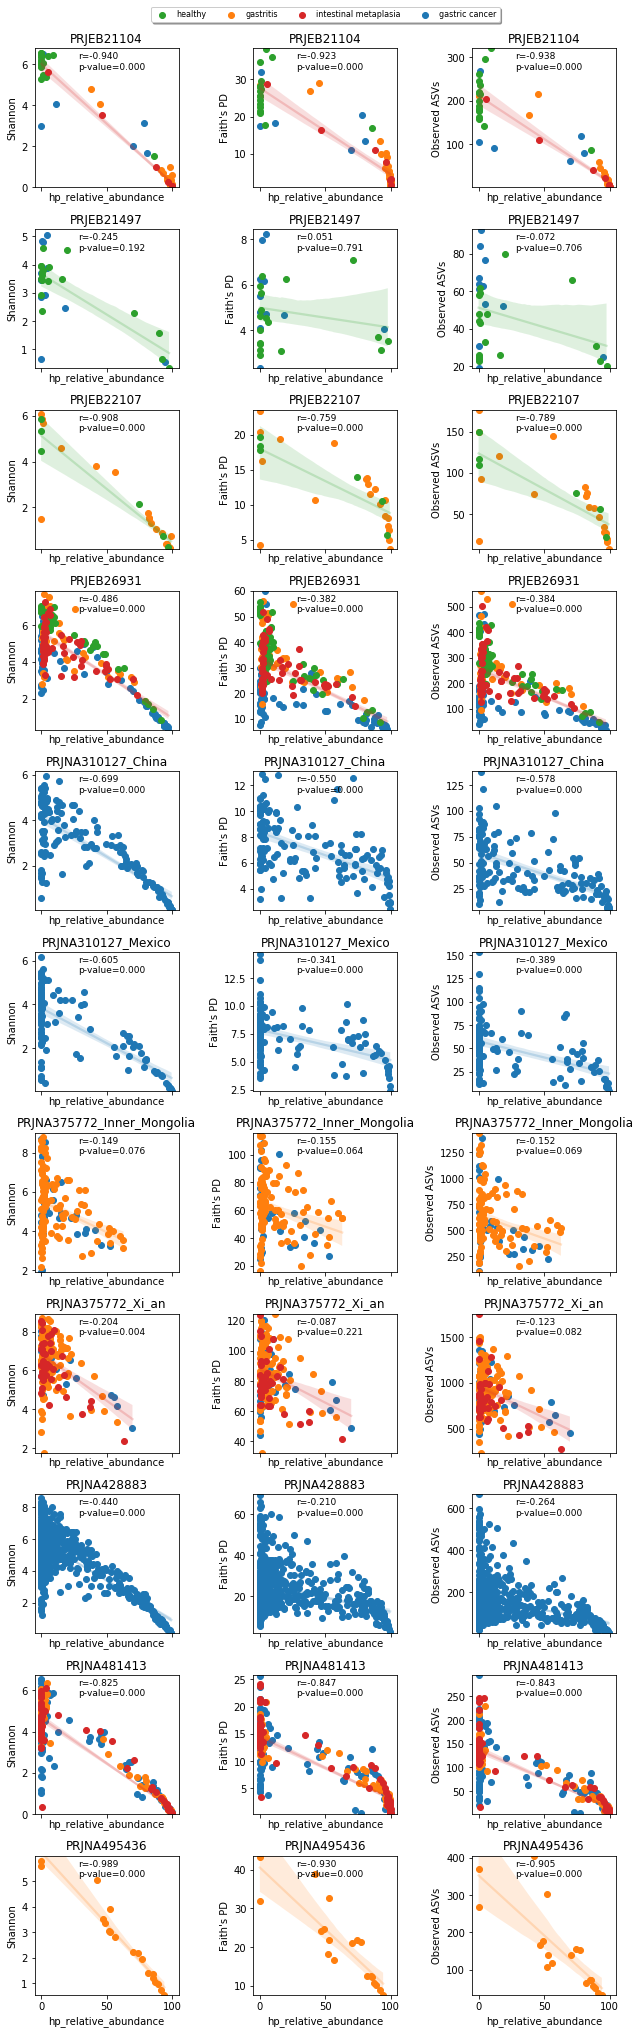

In [31]:
# plot scatter plot for hp_relative_abundance vs alpha diversity
    
alphas = ['Shannon',"Faith's PD", 'Observed ASVs']
b=['hp_relative_abundance','Diagnosis']+alphas

fig,axs = plt.subplots(11,3,figsize = (9,28),sharex=True)
fa=fig.axes
s=0
for study in bp:
    data=mdff.query('bioproject=="%s"' %study)[b].dropna()
    for alpha,ax,i in zip(alphas,fa[s:s+3],range(3)):
        
        plot_scatter(df = data,x= 'hp_relative_abundance',y = alpha,
                     group = 'Diagnosis',color_dict=color_dict,ax = ax)
        ax.legend_.remove()
        
        ax.set_title(study)    
        plt.tight_layout()
    s=s+3

handles, labels = fa[1].get_legend_handles_labels()
order = [2,1,3,0]
fa[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           loc='upper center', borderaxespad = 0.,bbox_to_anchor=(0.5, 1.3),prop={'size': 8},
          fancybox=True, shadow=True,ncol=4) 


#plt.savefig('figures/hpRelabundance_correlation_alphadiv_scatterplot.pdf',bbox_inches='tight')   
#plt.close()

# alpha div change in different sample location
## 26931


In [32]:
D26931=md.query("BioProject=='PRJEB26931'")
D26931['Sample_location'].fillna(D26931['Tissue'],inplace=True)

/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [33]:
D26931['Condition'].value_counts()

gastric cancer               84
intraepithelial neoplasia    75
healthy                      56
intestinal metaplasia        54
chronic gastritis            41
Name: Condition, dtype: int64

In [34]:
D26931=D26931.query('Condition !="intraepithelial neoplasia"')

In [35]:
D26931['Sample_location'].value_counts(dropna=False)

Antrum             104
Body               102
tumorous tissue     29
Name: Sample_location, dtype: int64

In [36]:
mdp = D26931[D26931.groupby('Subject_id').Subject_id .transform(len) > 1] 
mdp.shape

(230, 56)

In [37]:
mdp.pivot_table(values='BioProject',index=['Condition'],columns=['Sample_location'],aggfunc='count',dropna=True)

Sample_location,Antrum,Body,tumorous tissue
Condition,,,
chronic gastritis,20.0,20.0,NaN
gastric cancer,27.0,28.0,29.0
healthy,26.0,26.0,NaN
intestinal metaplasia,27.0,27.0,NaN


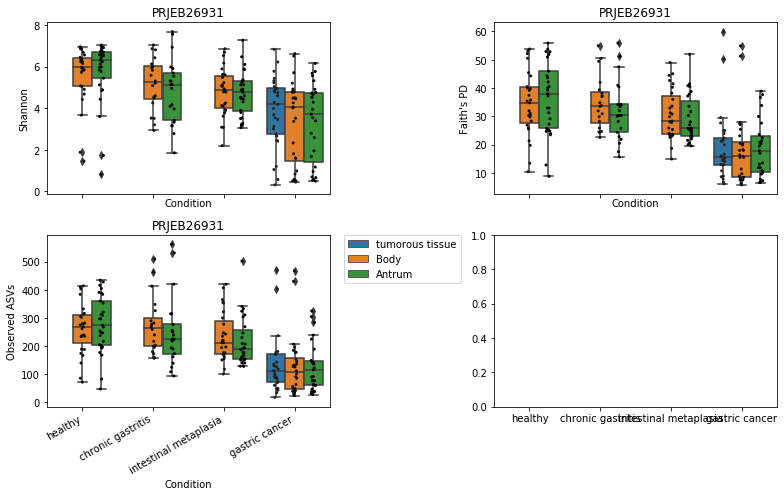

In [38]:

data=D26931
order=['healthy','chronic gastritis','intestinal metaplasia','gastric cancer']
fig,axs = plt.subplots(2,2,figsize=(11,7),sharex=True)
for alpha,ax,i in zip(alphas,fig.axes,range(4)):
    sns.boxplot(x="Condition", y=alpha, data=data,order =order,hue='Sample_location',
                #hue_order=order,
                ax=ax)
    sns.stripplot(x="Condition", y=alpha, data=data,color="black",ax=ax,dodge=True,size=3,order =order,
                 hue='Sample_location',
                  #hue_order=order,
                 )
    if i<2 :
        ax.legend_.remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        n=len(data['Sample_location'].unique().tolist())
        ax.legend(handles[:n], labels[:n], loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right') 
    ax.set_title('PRJEB26931')
plt.tight_layout()
#plt.savefig('figures/PRJEB26931-samplesite-alphadiv-boxplot.pdf')

In [39]:
for c in ['healthy','chronic gastritis','intestinal metaplasia']:
    df=D26931.query("Condition=='%s'" %c)
    df=df[df.groupby('Subject_id').Subject_id .transform(len) > 1]
    
    print('\n## ',c,': Body vs Antrum')

    for alpha in alphas:
        DF1= df.query("Sample_location=='Body'" ).sort_values(by='Subject_id')
        DF2= df.query("Sample_location=='Antrum'").sort_values(by='Subject_id')
        
        if DF1['Subject_id'].to_list()==DF2['Subject_id'].to_list():
            s1=DF1[alpha]
            s2=DF2[alpha]
           
            st,pvalue = stats.ttest_rel(s1,s2)
           
            if pvalue <= 0.01:
                sin="**"
            elif 0.01 <pvalue <= 0.05:
                sin='*'
            else:
                sin=''
            print(alpha,': pvalue=',pvalue,sin)
        else:
            print('not paried samples')


##  healthy : Body vs Antrum
Shannon : pvalue= 0.34581773357796874 
Faith's PD : pvalue= 0.09288392991927978 
Observed ASVs : pvalue= 0.1199043537019162 

##  chronic gastritis : Body vs Antrum
Shannon : pvalue= 0.32176826503888717 
Faith's PD : pvalue= 0.3769703124824141 
Observed ASVs : pvalue= 0.527835065938963 

##  intestinal metaplasia : Body vs Antrum
Shannon : pvalue= 0.7888523035553919 
Faith's PD : pvalue= 0.5437305072592954 
Observed ASVs : pvalue= 0.46024221508894914 


In [40]:
#GC
site=['Antrum','Body','tumorous tissue']
gc=mdp.query("Condition=='gastric cancer'")

for a,b in combinations(site,2):
    df=gc.query("Sample_location=='%s' | Sample_location=='%s'" %(a,b))
    gcp=df[df.groupby('Subject_id').Subject_id .transform(len) > 1]


    print('\n## gastric cancer :',a ,'vs',b)
    for alpha in alphas:
        s1=gcp.query("Sample_location=='%s' " %a ).sort_values(by='Subject_id')[alpha]
        s2=gcp.query("Sample_location=='%s' " %b ).sort_values(by='Subject_id')[alpha]
        
        st,pvalue = stats.ttest_rel(s1,s2)
        
        if pvalue <= 0.01:
            sin="**"
        elif 0.01 <pvalue <= 0.05:
            sin='*'
        else:
            sin=''
        print(alpha,':', 'pvalue=',pvalue,sin)    


## gastric cancer : Antrum vs Body
Shannon : pvalue= 0.7533801947659988 
Faith's PD : pvalue= 0.9016855475138585 
Observed ASVs : pvalue= 0.6949605796653198 

## gastric cancer : Antrum vs tumorous tissue
Shannon : pvalue= 0.05916023740738513 
Faith's PD : pvalue= 0.8547564271268862 
Observed ASVs : pvalue= 0.7116895422174405 

## gastric cancer : Body vs tumorous tissue
Shannon : pvalue= 0.16289415811905095 
Faith's PD : pvalue= 0.8137020387146539 
Observed ASVs : pvalue= 0.6672877953124305 


In [41]:
p26931gc=gc
p26931gc.shape

(84, 56)

## 375772

In [42]:
D375772=md.query("BioProject=='PRJNA375772'")

In [43]:
D375772['Condition'].value_counts()

atrophic gastritis       117
superficial gastritis    110
gastric cancer            76
intestinal metaplasia     41
Name: Condition, dtype: int64

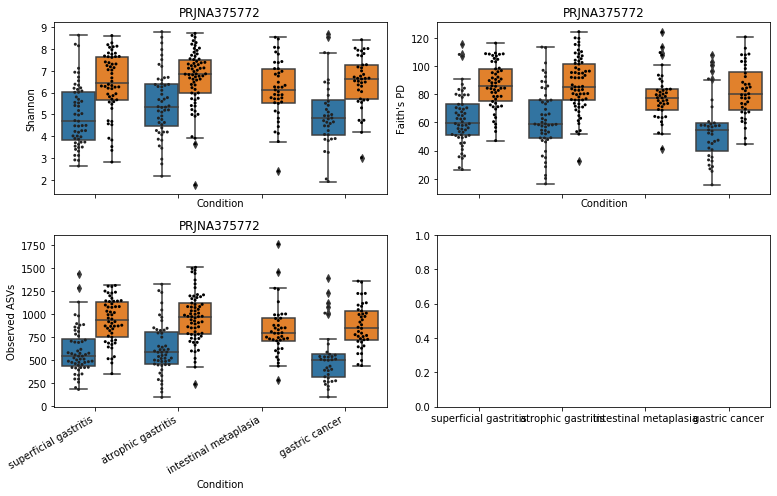

In [44]:
data=D375772
order=['superficial gastritis','atrophic gastritis','intestinal metaplasia','gastric cancer'] 

fig,axs = plt.subplots(2,2,figsize=(11,7),sharex=True)
for alpha,ax,i in zip(alphas,fig.axes,range(4)):
    sns.boxplot(x="Condition", y=alpha, data=data,order =order,hue='Region',
                #hue_order=order,
                ax=ax)
    sns.swarmplot(x="Condition", y=alpha, data=data,color="black",ax=ax,dodge=True,size=3,order =order,
                 hue='Region',
                  #hue_order=order,
                 )
    if i<3 :
        ax.legend_.remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        #n=len(data['Diagnosis'].unique().tolist())
        ax.legend(handles[:2], labels[:2], loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    ax.set_title('PRJNA375772')
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right') 
plt.tight_layout()
#plt.savefig('figures/PRJNA375772-alpha-city.pdf')

In [45]:
for c in ['superficial gastritis','atrophic gastritis','gastric cancer'] :
    df=D375772.query("Condition=='%s'" %c)
    print('\n## ',c,': Xian vs Inner Mongolia')

    for alpha in alphas:
        s1= df.query("Region=='Xian'" )[alpha]
        s2= df.query("Region=='Inner Mongolia'")[alpha]
        
        
        _,p = stats.levene(s1,s2)
        if p > 0.05 :
            st,pvalue = stats.ttest_ind(s1,s2)
        else:
            st,pvalue = stats.ttest_ind(s1,s2,equal_var=False)
        if pvalue <= 0.01:
            sin="**"
        elif 0.01 <pvalue <= 0.05:
            sin='*'
        else:
            sin=''
        print(alpha,': pvalue=',pvalue,sin)



##  superficial gastritis : Xian vs Inner Mongolia
Shannon : pvalue= 4.741626678322819e-07 **
Faith's PD : pvalue= 2.6775613523585557e-10 **
Observed ASVs : pvalue= 2.6932877699202474e-10 **

##  atrophic gastritis : Xian vs Inner Mongolia
Shannon : pvalue= 1.7832952709319443e-05 **
Faith's PD : pvalue= 3.6647427020690504e-09 **
Observed ASVs : pvalue= 1.3163934382595699e-09 **

##  gastric cancer : Xian vs Inner Mongolia
Shannon : pvalue= 1.6858027146105574e-05 **
Faith's PD : pvalue= 4.936023129084589e-07 **
Observed ASVs : pvalue= 1.0644863833867785e-06 **


### Xi'an

In [46]:
Dxian=D375772.query("Region=='Xian'")
Dnm=D375772.query("Region=='Inner Mongolia'")

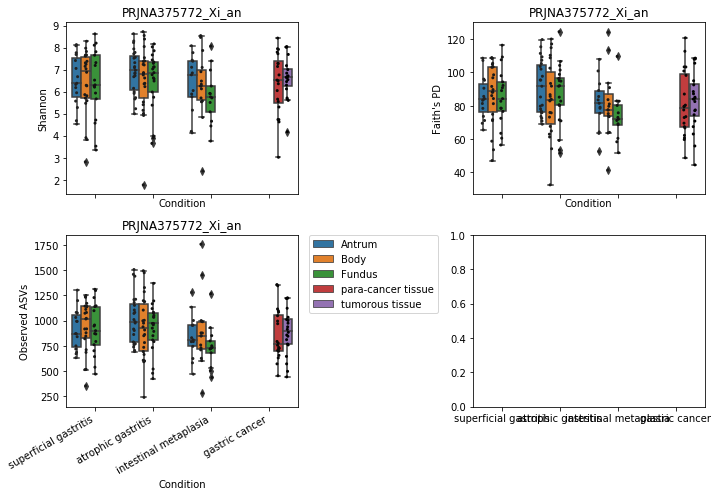

In [47]:
data=Dxian
order=['superficial gastritis','atrophic gastritis','intestinal metaplasia','gastric cancer'] 

fig,axs = plt.subplots(2,2,figsize=(10,7),sharex=True)
for alpha,ax,i in zip(alphas,fig.axes,range(4)):
    sns.boxplot(x="Condition", y=alpha, data=data,order =order,hue='Sample_location',
                #hue_order=order,
                ax=ax)
    sns.stripplot(x="Condition", y=alpha, data=data,color="black",ax=ax,dodge=True,size=3,order =order,
                 hue='Sample_location',
                  #hue_order=order,
                 )
    
    if i<2 :
        ax.legend_.remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        n=len(data['Sample_location'].unique().tolist())
        ax.legend(handles[:n], labels[:n], loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    ax.set_title("PRJNA375772_Xi_an")   
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right') 
    
plt.tight_layout()
#plt.savefig('figures/PRJNA375772-samplesite-alphadiv-boxplot.pdf')

In [48]:
site=['Antrum','Body','Fundus']

for c in ['superficial gastritis','atrophic gastritis','intestinal metaplasia']:
    
    df=Dxian.query("Condition=='%s'"%c)

    for a,b in combinations(site,2):
        print('\n##',c,':',a ,'vs',b)
        
        s_id=list(set(df.query("Sample_location=='%s'" %a)['Subject_id']) & set(df.query("Sample_location=='%s'" %b)['Subject_id']))
        xip=df[df['Subject_id'].isin(s_id)]
        
        for alpha in alphas:
            s1=xip.query("Sample_location=='%s' " %a ).sort_values(by='Subject_id')[alpha]
            s2=xip.query("Sample_location=='%s' " %b ).sort_values(by='Subject_id')[alpha]
            
            st,pvalue = stats.ttest_rel(s1,s2)
            
            if pvalue <= 0.01:
                sin="**"
            elif 0.01 <pvalue <= 0.05:
                sin='*'
            else:
                sin=''
            print(alpha,':', 'pvalue=',pvalue,sin) 


## superficial gastritis : Antrum vs Body
Shannon : pvalue= 0.9189544126459295 
Faith's PD : pvalue= 0.8624923708680776 
Observed ASVs : pvalue= 0.6538984169562456 

## superficial gastritis : Antrum vs Fundus
Shannon : pvalue= 0.6422596981976629 
Faith's PD : pvalue= 0.9722488806042016 
Observed ASVs : pvalue= 0.947329809969371 

## superficial gastritis : Body vs Fundus
Shannon : pvalue= 0.4796517075579999 
Faith's PD : pvalue= 0.5943136772261874 
Observed ASVs : pvalue= 0.503890609625907 

## atrophic gastritis : Antrum vs Body
Shannon : pvalue= 0.3194092511863911 
Faith's PD : pvalue= 0.4526365663950932 
Observed ASVs : pvalue= 0.5313743760867181 

## atrophic gastritis : Antrum vs Fundus
Shannon : pvalue= 0.36418805829435585 
Faith's PD : pvalue= 0.4856876828666611 
Observed ASVs : pvalue= 0.29508366098135164 

## atrophic gastritis : Body vs Fundus
Shannon : pvalue= 0.9845387483364297 
Faith's PD : pvalue= 0.6463156160570606 
Observed ASVs : pvalue= 0.9532073136861328 

## intes

In [49]:
# GC
gc=Dxian.query('Condition=="gastric cancer"')

s_id=list(set(gc.query("Tissue=='para-cancer tissue'")['Subject_id']) & set(gc.query("Tissue=='tumorous tissue'")['Subject_id']))
df=gc[gc['Subject_id'].isin(s_id)]
for alpha in alphas:
    s1=gc.query("Tissue=='para-cancer tissue'").sort_values(by='Subject_id')[alpha]
    s2=gc.query("Tissue=='tumorous tissue'" ).sort_values(by='Subject_id')[alpha]

    st,pvalue = stats.ttest_rel(s1,s2)

    if pvalue <= 0.01:
        sin="**"
    elif 0.01 <pvalue <= 0.05:
        sin='*'
    else:
        sin=''
    print(alpha,':', 'pvalue=',pvalue,sin) 

Shannon : pvalue= 0.4321203270556343 
Faith's PD : pvalue= 0.7030058786995327 
Observed ASVs : pvalue= 0.6745137888451411 


In [50]:
p375772gc=gc

### Inner Mongolia

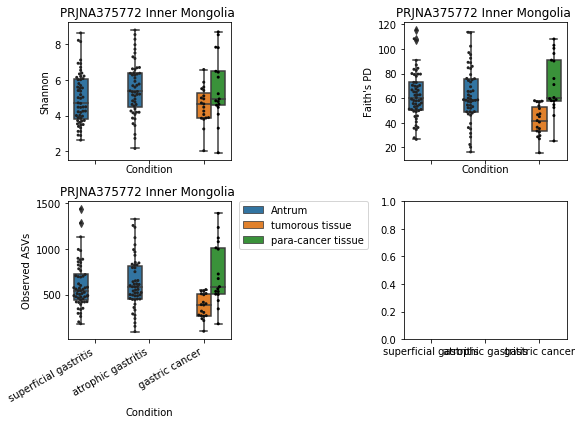

In [51]:
data=Dnm
order=['superficial gastritis','atrophic gastritis','gastric cancer'] 
hue_order=['Antrum','tumorous tissue','para-cancer tissue']
fig,axs = plt.subplots(2,2,figsize=(8,6),sharex=True)
for alpha,ax,i in zip(alphas,fig.axes,range(4)):
    sns.boxplot(x="Condition", y=alpha, data=data,order =order,hue='Sample_location',
                hue_order=hue_order,
                ax=ax)
    sns.swarmplot(x="Condition", y=alpha, data=data,color="black",ax=ax,dodge=True,size=3,order =order,
                 hue='Sample_location',
                hue_order=hue_order,
                 )
    if i<2 :
        ax.legend_.remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        n=len(data['Sample_location'].dropna().unique().tolist())
        ax.legend(handles[:n], labels[:n], loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    ax.set_title("PRJNA375772 Inner Mongolia ")
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right') 
plt.tight_layout()
#plt.savefig('figures/PRJNA375772_InnerMongolia_samplesite_alphadiv_boxplot.pdf')

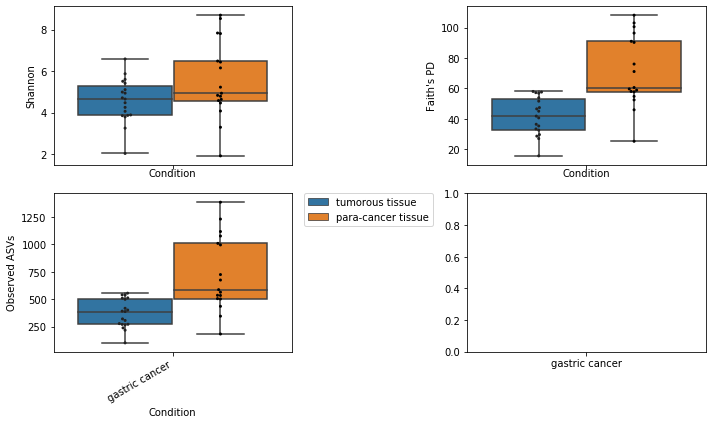

In [52]:
data=Dnm.query('Condition=="gastric cancer"')

fig,axs = plt.subplots(2,2,figsize=(10,6),sharex=True)

for alpha,ax,i in zip(alphas,fig.axes,range(4)):
    sns.boxplot(x="Condition", y=alpha, data=data,hue='Tissue',
                
                ax=ax)
    sns.swarmplot(x="Condition", y=alpha, data=data,color="black",ax=ax,dodge=True,size=3,
                 hue='Tissue',
                
                 )
    if i<2 :
        ax.legend_.remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        n=len(data['Tissue'].dropna().unique().tolist())
        ax.legend(handles[:n], labels[:n], loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right') 
plt.tight_layout()

In [53]:
print('Inner Mongolia sample tumorous tissue vs para-cancer tissue')
for alpha in alphas:
    s1=Dnm.query('Condition=="gastric cancer"').query("Tissue=='tumorous tissue' ")[alpha]
    s2=Dnm.query('Condition=="gastric cancer"').query("Tissue=='para-cancer tissue' " )[alpha]
    _,p = stats.levene(s1,s2)
    if p > 0.05 :
        st,pvalue = stats.ttest_ind(s1,s2)
    else:
        st,pvalue = stats.ttest_ind(s1,s2,equal_var=False)
    if pvalue <= 0.01:
        sin="**"
    elif 0.01 <pvalue <= 0.05:
        sin='*'
    else:
        sin=''
    print(alpha,':', 'pvalue=',pvalue,sin) 
    
# not paried sample    

Inner Mongolia sample tumorous tissue vs para-cancer tissue
Shannon : pvalue= 0.053043684589832975 
Faith's PD : pvalue= 0.00011305927736684537 **
Observed ASVs : pvalue= 0.0005590207141140443 **


## 310127

### alpha div

In [54]:
D310127=md.query("BioProject=='PRJNA310127'")

In [55]:
D310127_par = D310127[D310127.groupby('Subject_id').Subject_id.transform(len) > 1]
D310127_par.pivot_table(values='Name',index='Country', columns='Tissue',aggfunc='count',dropna=False)

Tissue,non_tumor_tissue,tumorous tissue
Country,,
China,74,74
Mexico,44,44


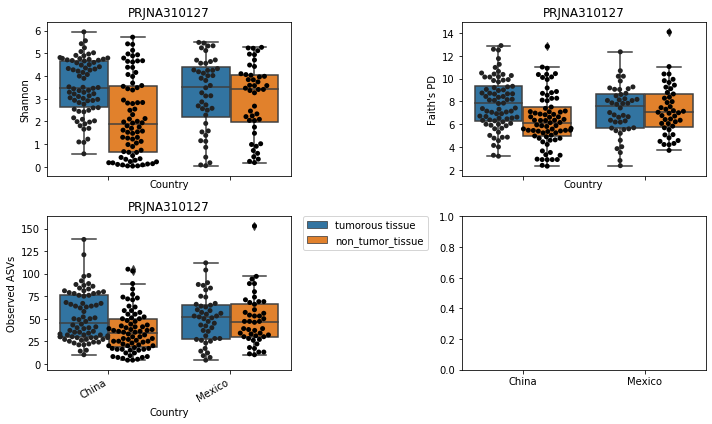

In [56]:


fig,axs = plt.subplots(2,2,figsize=(10,6),sharex=True)

for alpha,ax,i in zip(alphas,fig.axes,range(4)):
    sns.boxplot(x="Country", y=alpha, 
                   data=D310127_par,hue='Tissue',ax=ax,
                   )
    sns.swarmplot(x="Country", y=alpha, 
                     data=D310127_par,hue='Tissue',ax=ax,
                     color="black",dodge=True)

    if i<2 :
        ax.legend_.remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        n=len(D310127_par['Tissue'].dropna().unique().tolist())
        ax.legend(handles[:n], labels[:n], loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    ax.set_title('PRJNA310127')    
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right') 
    
plt.tight_layout()
#plt.savefig('figures/PRJNA310127-samplesite-alphadiv-boxplot.pdf')

In [57]:
for i in ['China','Mexico']:
    print('## ',i,'tumorous tissue vs non_tumor_tissue')
    for alpha in alphas:
        s1=D310127_par.query('Country=="%s" & Tissue=="tumorous tissue"' % i).sort_values(by='Subject_id')[alpha]
        s2=D310127_par.query('Country=="%s"& Tissue=="non_tumor_tissue"' % i).sort_values(by='Subject_id')[alpha]
        res=stats.ttest_rel(s1,s2)
        print(alpha, 'pvalue:',res[1])

##  China tumorous tissue vs non_tumor_tissue
Shannon pvalue: 2.7876164429220318e-08
Faith's PD pvalue: 1.589025192597327e-05
Observed ASVs pvalue: 1.7775853147610905e-05
##  Mexico tumorous tissue vs non_tumor_tissue
Shannon pvalue: 0.23483212834220438
Faith's PD pvalue: 0.8984872542615066
Observed ASVs pvalue: 0.771744425863883


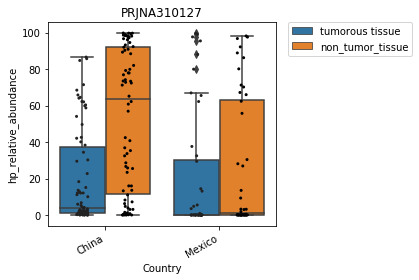

In [58]:
data=D310127_par
fig,ax = plt.subplots(figsize=(6,4))
sns.boxplot(x='Country', y='hp_relative_abundance', data=data,hue='Tissue',ax=ax)

sns.stripplot(x="Country", y='hp_relative_abundance', data=data,hue='Tissue',color="black",
                  size=3,dodge=True,
                  ax=ax)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[:2], labels[:2], loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

plt.setp(ax.get_xticklabels(), rotation=30, ha='right') 
ax.set_title('PRJNA310127')
plt.tight_layout()

In [59]:
s1=D310127_par.query('Country=="China"')['hp_relative_abundance']
s2=D310127_par.query('Country=="Mexico"')['hp_relative_abundance']
_,p = stats.levene(s1,s2)
if p > 0.05 :
    st,pvalue = stats.ttest_ind(s1,s2)
else:
    st,pvalue = stats.ttest_ind(s1,s2,equal_var=False)
if pvalue <= 0.01:
    sin="**"
elif 0.01 <pvalue <= 0.05:
    sin='*'
else:
    sin=''
print('hp_relative_abundance China vs Mexico :', 'pvalue=',pvalue,sin) 


hp_relative_abundance China vs Mexico : pvalue= 0.00742219342819452 **


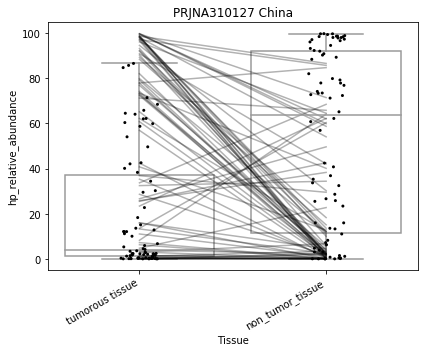

In [60]:
data=D310127_par.query('Country=="China"')
fig,ax = plt.subplots(figsize=(6,5))
sns.boxplot(x='Tissue', y='hp_relative_abundance', data=data,ax=ax,color='white')

sns.stripplot(x="Tissue", y='hp_relative_abundance', data=data,color="black",
                  size=3,dodge=True,
                  ax=ax)
sns.lineplot(x='Tissue', y='hp_relative_abundance', hue='Subject_id',data=data,
             ax=ax,palette=['black'] * 74, legend=False,alpha=0.3)


plt.setp(ax.get_xticklabels(), rotation=30, ha='right') 
ax.set_title('PRJNA310127 China')
plt.tight_layout()

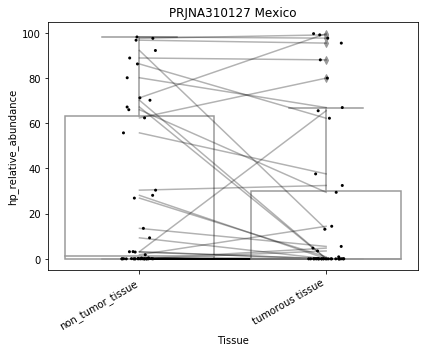

In [61]:
data=D310127_par.query('Country=="Mexico"')
fig,ax = plt.subplots(figsize=(6,5))
sns.boxplot(x='Tissue', y='hp_relative_abundance', data=data,ax=ax,color='white')

sns.stripplot(x="Tissue", y='hp_relative_abundance', data=data,color="black",
                  size=3,dodge=True,
                  ax=ax)
sns.lineplot(x='Tissue', y='hp_relative_abundance', hue='Subject_id',data=data,
             ax=ax,palette=['black'] * 44, legend=False,alpha=0.3)


plt.setp(ax.get_xticklabels(), rotation=30, ha='right') 
ax.set_title('PRJNA310127 Mexico')
plt.tight_layout()

### corelation of diff value alpha_div and hp_relative_abun

In [62]:
ntu=D310127_par.query('Tissue=="non_tumor_tissue"').set_index('Subject_id').sort_index()[['hp_relative_abundance','Shannon', "Faith's PD", 'Observed ASVs']]
tu=D310127_par.query('Tissue=="tumorous tissue"').set_index('Subject_id').sort_index()[['hp_relative_abundance','Shannon', "Faith's PD", 'Observed ASVs']]

In [63]:
all(ntu.index==tu.index)

True

In [64]:
all(ntu.columns==tu.columns)

True

In [65]:
diff=ntu-tu
diff=pd.concat([diff,D310127_par.query('Tissue=="tumorous tissue"').set_index('Subject_id').sort_index()[['Diagnosis','Country']]],axis=1)
diff.head()

,hp_relative_abundance,Shannon,Faith's PD,Observed ASVs,Diagnosis,Country
Subject_id,,,,,,
1CG.014,0.000000,-1.877828,-4.091169,-29,gastric cancer,Mexico
3CG.008,67.115192,-1.569250,0.230517,-4,gastric cancer,Mexico
3CG.009,0.097542,-1.345139,-0.207530,-7,gastric cancer,Mexico
3CG.014,24.016724,-1.699083,-2.321917,-21,gastric cancer,Mexico
3CG.015,79.094644,-3.916248,-2.252178,-24,gastric cancer,Mexico


In [66]:
def plot_scatter2(df,x,y, title='', cmap=None, cor=stats.spearmanr,group=None, ax=None,color_dict=None, **kwargs):
    import itertools
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    if ax is None:
        fig, ax = plt.subplots()
   
    if group is not None:
        for grp, DF in df.groupby(group):
            ax.scatter(DF[x], DF[y],
                       color=color_dict[grp],
                       label=grp,
                       **kwargs)
        ax.legend(loc="lower right")
        sns.regplot(x,y,data=df,scatter=False,ax=ax,line_kws={'color':color_dict[grp], 'alpha':.2})
    else:
        #ax.scatter(df[x], df[y], **kwargs)
        sns.regplot(x,y,data=df,scatter=False,ax=ax,line_kws={'alpha':.2})
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title)
    #ax.set_xlim([-5,105])
    #ax.set_ylim([df[y].min()-0.1,df[y].max()+0.2])
    
    if cor is not None:
        r, p = cor(df[x], df[y])
        ax.annotate("r={0:.3f} p-value={1:.3f}".format(r, p), xy=(.15, .92),fontsize=12, xycoords=ax.transAxes)
    return ax

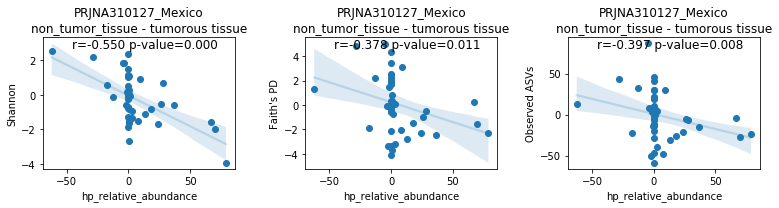

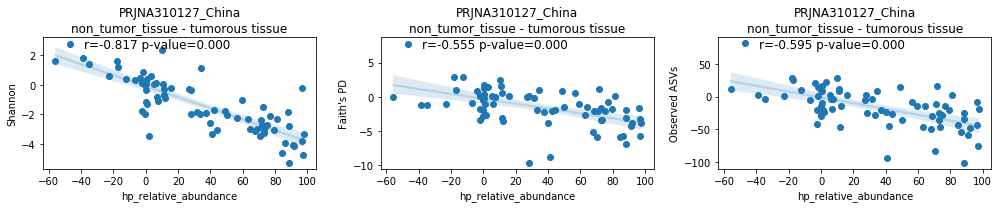

In [67]:
data=diff.query('Country=="Mexico"')

with PdfPages('figures/PRJNA310127-hpRelabund_alphadiv_dv_correlation_scatterplot.pdf') as pdf:
    fig,axs=plt.subplots(1,3,figsize=(11,3))
    for alpha,ax in zip(alphas,fig.axes):
        plot_scatter2(df = data,x= 'hp_relative_abundance',y = alpha,
                     group ='Diagnosis',color_dict=color_dict,ax=ax)


        ax.set_title('PRJNA310127_Mexico\nnon_tumor_tissue - tumorous tissue')
        ax.legend_.remove()
    plt.tight_layout()
    pdf.savefig()
    

    data=diff.query('Country=="China"')
    fig,axs=plt.subplots(1,3,figsize=(14,3))
    for alpha,ax in zip(alphas,fig.axes):
        plot_scatter2(df = data,x= 'hp_relative_abundance',y = alpha,
                     group ='Diagnosis',color_dict=color_dict,ax=ax)


        ax.set_title('PRJNA310127_China\nnon_tumor_tissue - tumorous tissue')
        ax.legend_.remove()
    plt.tight_layout()
    pdf.savefig()
    #plt.savefig('figures/PRJNA310127-samplesite-pariedsample-diffvalue-hpRelabundance_correlation_alphadiv_scatterplot-Antrumbodytumoroustissue.pdf',bbox_inches='tight')       


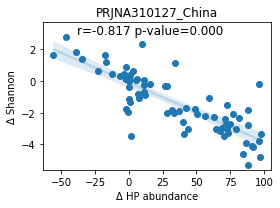

In [68]:
data=diff.query('Country=="China"')
fig,ax=plt.subplots(1,1,figsize=(4,3))

plot_scatter2(df = data,x= 'hp_relative_abundance',y = 'Shannon',
             group ='Diagnosis',color_dict=color_dict,ax=ax)


ax.set_title('PRJNA310127_China')
ax.set_ylabel('Δ Shannon')
ax.set_xlabel('Δ HP abundance')
ax.set_ylim(-5.6,3.7)
ax.legend_.remove()
plt.tight_layout()
#plt.savefig('figures/PRJNA310127_China-non_tumor_tissue-tumorous-tissue-cor.pdf')

## 481413

In [69]:
D481413=md.query("BioProject=='PRJNA481413'")

In [70]:
D481413['Condition'].replace({'gastritis':'Gastritis',
                             'intestinal metaplasia':'IM',
                             'gastric cancer':'GC'},inplace=True)

/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


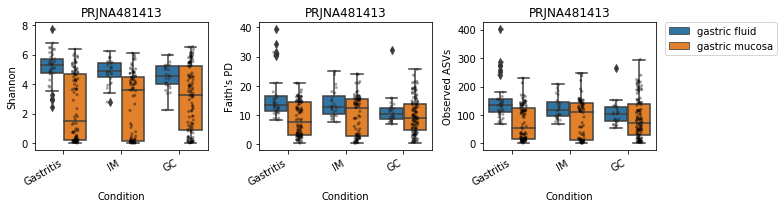

In [71]:
data=D481413
order=['Gastritis','IM','GC'] 

fig,axs = plt.subplots(1,3,figsize=(11,3),sharex=True)
for alpha,ax,i in zip(alphas,fig.axes,range(4)):
    sns.boxplot(x="Condition", y=alpha, data=data,order =order,hue='Sample_type',
                #hue_order=order,
                ax=ax)
    sns.stripplot(x="Condition", y=alpha, data=data,color="black",ax=ax,dodge=True,size=3,order =order,
                 hue='Sample_type',alpha=0.4,
                  #hue_order=order,
                 )
    if i<2 :
        ax.legend_.remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        n=len(data['Sample_type'].unique().tolist())
        ax.legend(handles[:n], labels[:n], loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    ax.set_title('PRJNA481413')
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right') 
plt.tight_layout()
#plt.savefig('figures/PRJNA481413-sampletype-alphadiv-boxplot.pdf')

In [72]:
for c in ['Gastritis','IM',"GC"]:
    df=D481413.query("Condition=='%s'" %c)
    
    
    print('\n## ',c,': mucosa vs fluid')

    for alpha in alphas:
        s1= df.query("Sample_type=='gastric mucosa'" )[alpha]
        s2= df.query("Sample_type=='gastric fluid'")[alpha]
        
       
           
        _,p = stats.levene(s1,s2)
        if p > 0.05 :
            st,pvalue = stats.ttest_ind(s1,s2)
        else:
            st,pvalue = stats.ttest_ind(s1,s2,equal_var=False)
        if pvalue <= 0.01:
            sin="**"
        elif 0.01 <pvalue <= 0.05:
            sin='*'
        else:
            sin=''
        print(alpha,': pvalue=',pvalue,sin)


##  Gastritis : mucosa vs fluid
Shannon : pvalue= 4.2300370470048766e-17 **
Faith's PD : pvalue= 4.7829466034497295e-09 **
Observed ASVs : pvalue= 9.546345049831548e-10 **

##  IM : mucosa vs fluid
Shannon : pvalue= 7.72116898907486e-12 **
Faith's PD : pvalue= 0.0009519850860347901 **
Observed ASVs : pvalue= 0.0006874977583488508 **

##  GC : mucosa vs fluid
Shannon : pvalue= 8.354706451353603e-08 **
Faith's PD : pvalue= 0.13499196254857898 
Observed ASVs : pvalue= 0.10544518060916748 


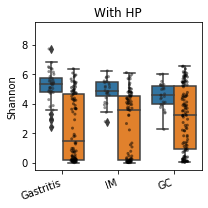

In [73]:
data=D481413
order=['Gastritis','IM','GC'] 

fig,ax = plt.subplots(1,1,figsize=(3,3))

sns.boxplot(x="Condition", y='Shannon', data=data,order =order,hue='Sample_type',
            #hue_order=order,
            ax=ax)
sns.stripplot(x="Condition", y='Shannon', data=data,color="black",ax=ax,dodge=True,
              size=3,order =order,
             hue='Sample_type',alpha=0.5,
              #hue_order=order,
             )

ax.legend_.remove()
ax.set_title('With HP')
plt.setp(ax.get_xticklabels(), rotation=20, ha='right') 
ax.set_xlabel('')
ax.set_ylim(-0.5,9.5)
plt.tight_layout()
#plt.savefig('figures/PRJNA481413-sampletype-alphadiv-Shannon-boxplot.pdf')

In [74]:
# fluid sample compare disease stage
for a,b in combinations(['Gastritis','IM','GC'],2):
    gf=D481413.query("Sample_type=='gastric fluid'")

    print('\n## ',a,'vs',b)
    for alpha in alphas: 
        s1=gf.query("Condition=='%s'" %a)[alpha]
        s2=gf.query("Condition=='%s'" %b)[alpha]

        _,p = stats.levene(s1,s2)
        if p > 0.05 :
            st,pvalue = stats.ttest_ind(s1,s2)
        else:
            st,pvalue = stats.ttest_ind(s1,s2,equal_var=False)
        if pvalue <= 0.01:
            sin="**"
        elif 0.01 <pvalue <= 0.05:
            sin='*'
        else:
            sin=''
        print(alpha,': pvalue=',pvalue,sin) 


##  Gastritis vs IM
Shannon : pvalue= 0.25429425634654024 
Faith's PD : pvalue= 0.247561407637443 
Observed ASVs : pvalue= 0.12218139284268785 

##  Gastritis vs GC
Shannon : pvalue= 0.01848896471364635 *
Faith's PD : pvalue= 0.005144324676604677 **
Observed ASVs : pvalue= 0.0036149081426643777 **

##  IM vs GC
Shannon : pvalue= 0.16821327809772016 
Faith's PD : pvalue= 0.038835476380568244 *
Observed ASVs : pvalue= 0.06503043831031313 


In [75]:
# mucosa sample compare disease stage
for a,b in combinations(['Gastritis','IM','GC'],2):
    gf=D481413.query("Sample_type=='gastric mucosa'")

    print('\n## ',a,'vs',b)
    for alpha in alphas: 
        s1=gf.query("Condition=='%s'" %a)[alpha]
        s2=gf.query("Condition=='%s'" %b)[alpha]

        _,p = stats.levene(s1,s2)
        if p > 0.05 :
            st,pvalue = stats.ttest_ind(s1,s2)
        else:
            st,pvalue = stats.ttest_ind(s1,s2,equal_var=False)
        if pvalue <= 0.01:
            sin="**"
        elif 0.01 <pvalue <= 0.05:
            sin='*'
        else:
            sin=''
        print(alpha,': pvalue=',pvalue,sin) 


##  Gastritis vs IM
Shannon : pvalue= 0.4856223352118214 
Faith's PD : pvalue= 0.1895112844323676 
Observed ASVs : pvalue= 0.147423574439134 

##  Gastritis vs GC
Shannon : pvalue= 0.030917713030625273 *
Faith's PD : pvalue= 0.1897925028650292 
Observed ASVs : pvalue= 0.08211042074744228 

##  IM vs GC
Shannon : pvalue= 0.17987408605295274 
Faith's PD : pvalue= 0.8617740981697297 
Observed ASVs : pvalue= 0.8756589946041263 


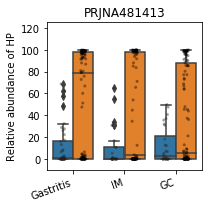

In [76]:
data=D481413
#order=['gastritis','intestinal metaplasia','gastric cancer'] 

fig,ax = plt.subplots(figsize=(3,3),sharex=True)

sns.boxplot(x="Condition", y='hp_relative_abundance', data=data,order =order,hue='Sample_type',
                #hue_order=order,
                ax=ax)
sns.stripplot(x="Condition", y='hp_relative_abundance', data=data,color="black",ax=ax,dodge=True,size=3,order =order,
                 hue='Sample_type',alpha=0.4,
                  #hue_order=order,
                 )

ax.set_title('PRJNA481413')
ax.legend_.remove()
ax.set_ylabel('Relative abundance of HP')
ax.set_xlabel('')
ax.set_ylim(-10,125)
plt.setp(ax.get_xticklabels(), rotation=20, ha='right') 
plt.tight_layout()
#plt.savefig('figures/PRJNA481413-sampletype-hpRelabund-boxplot.pdf')

In [77]:
# fluid vs mucosa
for c in ['Gastritis','IM','GC']:
        
    s1=D481413.query("Condition=='%s'" %c).query("Sample_type=='gastric fluid'" )['hp_relative_abundance']
    s2=D481413.query("Condition=='%s'" %c).query("Sample_type=='gastric mucosa'" )['hp_relative_abundance']

    _,p = stats.levene(s1,s2)
    if p > 0.05 :
        st,pvalue = stats.ttest_ind(s1,s2)
    else:
        st,pvalue = stats.ttest_ind(s1,s2,equal_var=False)
    if pvalue <= 0.01:
        sin="**"
    elif 0.01 <pvalue <= 0.05:
        sin='*'
    else:
        sin=''
    print(c,":",pvalue,sin)

Gastritis : 4.8176919954574954e-12 **
IM : 2.989403677684881e-07 **
GC : 5.661084798071324e-06 **


In [78]:

from scipy.stats import ranksums
print('PRJNA481413 gastric fluid sample hp abundance wilcox test')
for a,b in combinations(['Gastritis','IM','GC'],2):
    gf=D481413.query("Sample_type=='gastric fluid'")

    print('\n## ',a,'vs',b)

    s1=gf.query("Condition=='%s'" %a)['hp_relative_abundance']
    s2=gf.query("Condition=='%s'" %b)['hp_relative_abundance']

    st,pvalue = ranksums(s1,s2)

    if pvalue <= 0.01:
        sin="**"
    elif 0.01 <pvalue <= 0.05:
        sin='*'
    else:
        sin=''
    print('pvalue=',pvalue,sin) 

PRJNA481413 gastric fluid sample hp abundance wilcox test

##  Gastritis vs IM
pvalue= 0.5432520704643824 

##  Gastritis vs GC
pvalue= 0.36909552751396213 

##  IM vs GC
pvalue= 0.1476491275796171 


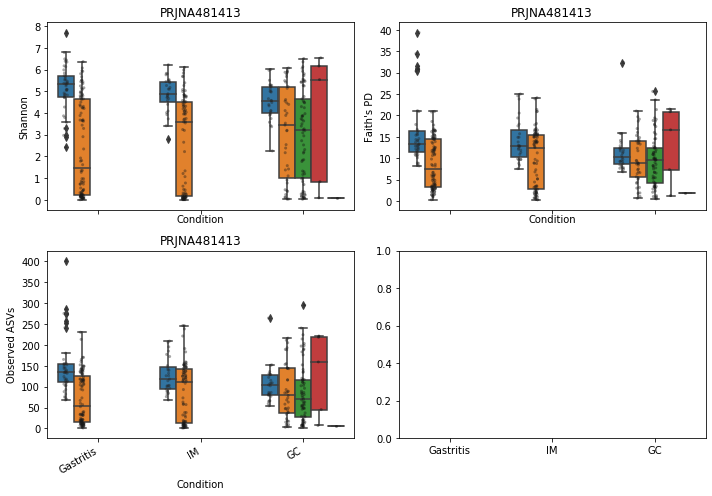

In [79]:
data=D481413
order=['Gastritis','IM','GC'] 

fig,axs = plt.subplots(2,2,figsize=(10,7),sharex=True)
for alpha,ax,i in zip(alphas,fig.axes,range(4)):
    sns.boxplot(x="Condition", y=alpha, data=data,order =order,hue='Sample_location',
                #hue_order=order,
                ax=ax)
    sns.stripplot(x="Condition", y=alpha, data=data,color="black",ax=ax,dodge=True,size=3,order =order,
                 hue='Sample_location',alpha=0.4,
                  #hue_order=order,
                 )
    if i<3 :
        ax.legend_.remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        n=len(data['Sample_location'].unique().tolist())
        ax.legend(handles[:n], labels[:n], loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    ax.set_title('PRJNA481413')
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right') 
plt.tight_layout()
#plt.savefig('figures/PRJNA481413-samplesite-alphadiv-boxplot.pdf')

In [80]:
for c in ['Gastritis','IM']:
    df=D481413.query("Condition=='%s'" %c)
    
    
    print('\n## ',c,': Body vs fluid')

    for alpha in alphas:
        s1= df.query("Sample_location=='Body'" )[alpha]
        s2= df.query("Sample_location=='fluid'")[alpha]
        
       
           
        _,p = stats.levene(s1,s2)
        if p > 0.05 :
            st,pvalue = stats.ttest_ind(s1,s2)
        else:
            st,pvalue = stats.ttest_ind(s1,s2,equal_var=False)
        if pvalue <= 0.01:
            sin="**"
        elif 0.01 <pvalue <= 0.05:
            sin='*'
        else:
            sin=''
        print(alpha,': pvalue=',pvalue,sin)
    


##  Gastritis : Body vs fluid
Shannon : pvalue= 4.2300370470048766e-17 **
Faith's PD : pvalue= 4.7829466034497295e-09 **
Observed ASVs : pvalue= 9.546345049831548e-10 **

##  IM : Body vs fluid
Shannon : pvalue= 7.72116898907486e-12 **
Faith's PD : pvalue= 0.0009519850860347901 **
Observed ASVs : pvalue= 0.0006874977583488508 **


In [81]:
site=['Antrum','Body','fluid','Fundus']
gc=D481413.query("Condition=='GC'")


for a,b in combinations(site,2):
    print('\n## gastric cancer :',a ,'vs',b)
    for alpha in alphas:
        s1=gc.query("Sample_location=='%s' " %a )[alpha]
        s2=gc.query("Sample_location=='%s' " %b )[alpha]
        _,p = stats.levene(s1,s2)
        if p > 0.05 :
            st,pvalue = stats.ttest_ind(s1,s2)
        else:
            st,pvalue = stats.ttest_ind(s1,s2,equal_var=False)
        if pvalue <= 0.01:
            sin="**"
        elif 0.01 <pvalue <= 0.05:
            sin='*'
        else:
            sin=''
        print(alpha,':', 'pvalue=',pvalue,sin)  


## gastric cancer : Antrum vs Body
Shannon : pvalue= 0.7689578398783794 
Faith's PD : pvalue= 0.8280436211254316 
Observed ASVs : pvalue= 0.7882214935335903 

## gastric cancer : Antrum vs fluid
Shannon : pvalue= 1.7895403438070484e-06 **
Faith's PD : pvalue= 0.12379608987835204 
Observed ASVs : pvalue= 0.09969994552554219 

## gastric cancer : Antrum vs Fundus
Shannon : pvalue= 0.4038680316903359 
Faith's PD : pvalue= 0.17216541848580444 
Observed ASVs : pvalue= 0.1910035014641528 

## gastric cancer : Body vs fluid
Shannon : pvalue= 0.0004420167196996762 **
Faith's PD : pvalue= 0.2205357692390765 
Observed ASVs : pvalue= 0.23217322848001598 

## gastric cancer : Body vs Fundus
Shannon : pvalue= 0.5106085791886125 
Faith's PD : pvalue= 0.19476292535546516 
Observed ASVs : pvalue= 0.22643497825236825 

## gastric cancer : fluid vs Fundus
Shannon : pvalue= 0.6375967981343682 
Faith's PD : pvalue= 0.4237607869086133 
Observed ASVs : pvalue= 0.6122659712874612 


## precancer_samplesite

In [82]:
p375772_26931 = md.query('bioproject=="PRJNA375772_Xi_an" | BioProject=="PRJEB26931"').query('Diagnosis!="gastric cancer"')
p375772_26931.shape

(312, 56)

In [83]:
p375772_26931p= p375772_26931[p375772_26931.groupby('Subject_id').Subject_id .transform(len) > 1] 
p375772_26931p.shape

(303, 56)

In [84]:
p375772_26931p.pivot_table(values='Name',index=['BioProject','Condition'],columns=['Sample_location'],aggfunc='count',dropna=True)

Sample_location                    Antrum  Body  Fundus
BioProject  Condition                                  
PRJEB26931  chronic gastritis        20.0  20.0     NaN
            healthy                  26.0  26.0     NaN
            intestinal metaplasia    27.0  27.0     NaN
PRJNA375772 atrophic gastritis       23.0  22.0    21.0
            intestinal metaplasia    13.0  13.0    13.0
            superficial gastritis    15.0  20.0    17.0

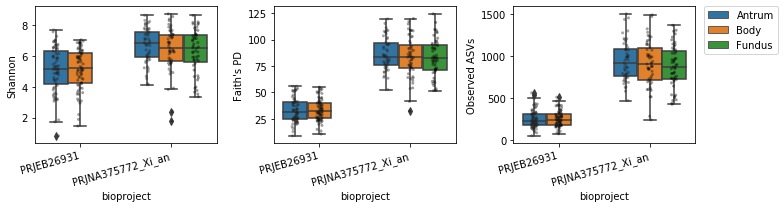

In [85]:
data=p375772_26931p
fig,axs = plt.subplots(1,3,figsize=(11,3),sharex=True)
for alpha,ax,i in zip(alphas,fig.axes,range(4)):
    sns.boxplot(x="bioproject", y=alpha, data=data,
                #order =order,
                hue='Sample_location',
                hue_order=['Antrum','Body','Fundus'],
                ax=ax)
    sns.stripplot(x="bioproject", y=alpha, data=data,color="black",ax=ax,dodge=True,size=3,
                  #order =order,
                 hue='Sample_location',alpha=0.4,
                  hue_order=['Antrum','Body','Fundus'],
                 )
    if i<2 :
        ax.legend_.remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        n=len(data['Sample_location'].unique().tolist())
        ax.legend(handles[:n], labels[:n], loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    #ax.set_title('tumor_vs_non-tumor')
    plt.setp(ax.get_xticklabels(), rotation=15, ha='right') 
plt.tight_layout()
#plt.savefig('figures/precancer_samplesite_boxplot.pdf')

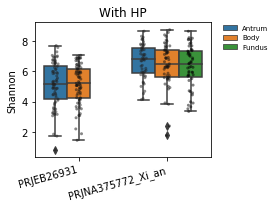

In [86]:
data=p375772_26931p
fig,ax = plt.subplots(1,1,figsize=(4,3))

sns.boxplot(x="bioproject", y='Shannon', data=data,
            #order =order,
            hue='Sample_location',
            hue_order=['Antrum','Body','Fundus'],
            ax=ax)
sns.stripplot(x="bioproject", y='Shannon', data=data,color="black",ax=ax,dodge=True,size=3,
              #order =order,
             hue='Sample_location',alpha=0.5,
              hue_order=['Antrum','Body','Fundus'],
             )

handles, labels = ax.get_legend_handles_labels()
n=len(data['Sample_location'].unique().tolist())
ax.legend(handles[:n], labels[:n], loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.,
         frameon=False,prop = {'size':7})
#ax.set_title('tumor_vs_non-tumor')
ax.set_xlabel('')
plt.setp(ax.get_xticklabels(), rotation=15, ha='right')
plt.title('With HP')
plt.tight_layout()
#plt.savefig('figures/precancer_samplesite_Shannon-boxplot.pdf')

In [87]:
print('## PRJEB26931 body vs Antrum paried t test:')

p931 = p375772_26931p.query('BioProject== "PRJEB26931"')
df = p931
for alpha in alphas:
    DF1= df.query("Sample_location=='Body'" ).sort_values(by='Subject_id')
    DF2= df.query("Sample_location=='Antrum'").sort_values(by='Subject_id')

    if DF1['Subject_id'].to_list()==DF2['Subject_id'].to_list():
        s1=DF1[alpha]
        s2=DF2[alpha]

        st,pvalue = stats.ttest_rel(s1,s2)
        if pvalue <= 0.01:
            sin="**"
        elif 0.01 <pvalue <= 0.05:
            sin='*'
        else:
            sin=''
        print(alpha,': pvalue=',pvalue,sin)
    else:
        print('not paried samples')

## PRJEB26931 body vs Antrum paried t test:
Shannon : pvalue= 0.7405597202007606 
Faith's PD : pvalue= 0.7714152764799317 
Observed ASVs : pvalue= 0.6940895572710721 


In [88]:
print('PRJNA375772 paried t test:')
p772 = p375772_26931p.query('BioProject== "PRJNA375772"')
for a,b in combinations(['Body','Antrum','Fundus'],2):
    df=p772.query('Sample_location=="%s" | Sample_location=="%s" '%(a,b))
    s_id=list(set(df.query("Sample_location=='%s'" %a)['Subject_id']) & set(df.query("Sample_location=='%s'" %b)['Subject_id']))
    dfp=df[df['Subject_id'].isin(s_id)]
    
    print('\n## ',a,'vs',b)

    for alpha in alphas:
        DF1= dfp.query("Sample_location=='%s'" %a ).sort_values(by='Subject_id')
        DF2= dfp.query("Sample_location=='%s'" %b).sort_values(by='Subject_id')
        
        if DF1['Subject_id'].to_list()==DF2['Subject_id'].to_list():
            s1=DF1[alpha]
            s2=DF2[alpha]

            st,pvalue = stats.ttest_rel(s1,s2)
            if pvalue <= 0.01:
                sin="**"
            elif 0.01 <pvalue <= 0.05:
                sin='*'
            else:
                sin=''
            print(alpha,': pvalue=',pvalue,sin)
        else:
            print('not paried samples')

PRJNA375772 paried t test:

##  Body vs Antrum
Shannon : pvalue= 0.280160999910612 
Faith's PD : pvalue= 0.3812384964050134 
Observed ASVs : pvalue= 0.6135766080488114 

##  Body vs Fundus
Shannon : pvalue= 0.5979808960944051 
Faith's PD : pvalue= 0.9522697501854881 
Observed ASVs : pvalue= 0.535008279259235 

##  Antrum vs Fundus
Shannon : pvalue= 0.09177393625277912 
Faith's PD : pvalue= 0.18740202830284347 
Observed ASVs : pvalue= 0.12038913432397035 


## tumor vs non tumor plot

In [89]:
t_nt=pd.concat([D310127_par,p26931gc,p375772gc])

In [90]:
t_nt.shape

(360, 56)

In [91]:
t_nt['Sample_location'].fillna(t_nt['Tissue'],inplace=True)

In [92]:
t_nt['Region'].fillna('PRJEB26931',inplace=True)

In [93]:
t_nt['cohort']=t_nt['Region'].replace({'Shanxi':'PRJNA310127_China',
                                      'Mexico':'PRJNA310127_Mexico',
                                     'PRJEB26931':'PRJEB26931',
                                      'Xian':'PRJNA375772_Xi_an'})

In [94]:
t_nt['cohort'].value_counts()

PRJNA310127_China     148
PRJNA310127_Mexico     88
PRJEB26931             84
PRJNA375772_Xi_an      40
Name: cohort, dtype: int64

In [95]:
t_nt['Sample_location'].value_counts(dropna=False)

tumorous tissue       167
non_tumor_tissue      118
Body                   28
Antrum                 27
para-cancer tissue     20
Name: Sample_location, dtype: int64

In [96]:
t_nt['Sample_location'].replace({'Body':'Non-tumor tissue',
                                'Antrum':'Non-tumor tissue',
                                'para-cancer tissue':'Non-tumor tissue',
                                'tumorous tissue' :'Tumorous tissue',
                                'non_tumor_tissue':'Non-tumor tissue'},inplace=True)

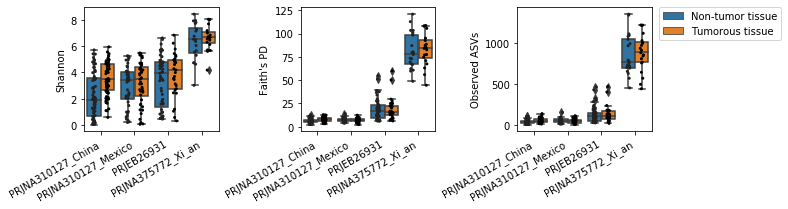

In [97]:
data=t_nt

fig,axs = plt.subplots(1,3,figsize=(11,3),sharex=True)
for alpha,ax,i in zip(alphas,fig.axes,range(4)):
    sns.boxplot(x="cohort", y=alpha, data=data,
                #order =order,
                hue='Sample_location',
                hue_order=['Non-tumor tissue','Tumorous tissue'],
                ax=ax)
    sns.stripplot(x="cohort", y=alpha, data=data,color="black",ax=ax,dodge=True,size=3,
                 hue_order=['Non-tumor tissue','Tumorous tissue'],
                  hue='Sample_location',
                 )
    if i<2 :
        ax.legend_.remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        n=len(data['Sample_location'].unique().tolist())
        ax.legend(handles[:n], labels[:n], loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    
    ax.set_xlabel('')
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right') 
plt.tight_layout()
plt.savefig('figures/tumor_vs_non_tumor_tissue_boxplot.pdf')

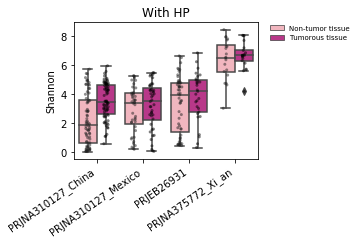

In [98]:
data=t_nt
#order=['gastritis','intestinal metaplasia','gastric cancer'] 

fig,ax = plt.subplots(1,1,figsize=(5,3.5))

sns.boxplot(x="cohort", y='Shannon', data=data,palette='RdPu',
            #order =order,
            hue='Sample_location',
            hue_order=['Non-tumor tissue','Tumorous tissue'],
            ax=ax)
sns.stripplot(x="cohort", y='Shannon', data=data,color="black",ax=ax,dodge=True,size=3,alpha=0.5,
             hue_order=['Non-tumor tissue','Tumorous tissue'],
              hue='Sample_location',
             )

handles, labels = ax.get_legend_handles_labels()
n=len(data['Sample_location'].unique().tolist())
ax.legend(handles[:n], labels[:n], loc=2,bbox_to_anchor=(1.05,1.0),borderaxespad = 0.,
          frameon=False,prop = {'size':7})

ax.set_xlabel('')
plt.setp(ax.get_xticklabels(), rotation=35, ha='right') 
plt.title('With HP')
plt.tight_layout()
#plt.savefig('figures/tumor_vs_non_tumor_tissue_Shannon-boxplot.pdf')